<a href="https://colab.research.google.com/github/umutcankarakas/lstm-musicgenerator/blob/master/lstm_train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/umutcankarakas/lstm-musicgenerator.git

Cloning into 'lstm-musicgenerator'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 39 (delta 10), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (39/39), done.


In [2]:
!pip install keras-self-attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.47.0-cp36-none-any.whl size=17289 sha256=f15526a8f75fd879285ce648198979b4c62505451fc60538ae5c1fb0f4be48ea
  Stored in directory: /root/.cache/pip/wheels/70/87/01/76c703d5401b65e323927c1fdc665f3fb143282ff67d71e859
Successfully built keras-self-attention


In [3]:
import os
import numpy as np
from pathlib import *
import glob
import pickle
import numpy
from music21 import converter, instrument, note, chord, stream
from keras.models import Sequential
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.layers import Dense, Dropout, LSTM, Activation, Bidirectional, Flatten
#from keras import utils
from keras.callbacks import ModelCheckpoint
from keras_self_attention import SeqSelfAttention
from matplotlib import pyplot as plt
import string

In [4]:
os.chdir('lstm-musicgenerator')

In [5]:
train_path = 'data/'

In [6]:
def train_network():
    """ Train a Neural Network to generate music """
    notes = get_notes()

    # get amount of pitch names
    n_vocab = 128 + 128 + 2

    network_input, network_output = prepare_sequences(notes, n_vocab)

    model = create_network(network_input, n_vocab)
    history = train(model, network_input, network_output)
    return history

In [7]:
def convertMidi2Arr(midi_element):
  newlist = []
  max_duration = 8*4*4
  if isinstance(midi_element, note.Note):
    newlist.append(midi_element.pitch.midi)
    if int(round(midi_element.duration.quarterLength*4)) > max_duration:
      newlist.append(128 + max_duration)
    else:
      newlist.append(128 + int(round(midi_element.duration.quarterLength*4)))
  elif isinstance(midi_element, chord.Chord):
    for n in midi_element:
      newlist.append(n.pitch.midi) 
      if int(round(midi_element.duration.quarterLength*4)) > max_duration:
        newlist.append(128 + max_duration)
      else:
        newlist.append(128 + int(round(midi_element.duration.quarterLength*4)))
  elif isinstance(midi_element, note.Rest):
    newlist.append(128)
    if int(round(midi_element.duration.quarterLength*4)) > max_duration:
      newlist.append(128 + max_duration)
    else:
      newlist.append(128 + int(round(midi_element.duration.quarterLength*4)))
  return newlist

In [8]:
def get_notes():
  mylist = []
  count = 0
  last_offset = 0.0
  offset_diff = 0.0
  for file in glob.glob(train_path + '**/*.midi', recursive=True):
    try:
      midi = converter.parse(file)
    except:
      continue
    print("Parsing %s" % file)
    #print(count)
    notes_to_parse = None
    max_duration = 8*4*4

    try: # file has instrument parts
      s2 = instrument.partitionByInstrument(midi_piece)
      notes_to_parse = s2.parts[0].recurse() 
    except: # file has notes in a flat structure
      notes_to_parse = midi.flat.notesAndRests

    same_offset_elements = []
    #min_duration = max_duration
    for element in notes_to_parse:
      if isinstance(element, note.Note) or isinstance(element, chord.Chord) or isinstance(element, note.Rest):
        if( not same_offset_elements or same_offset_elements[0].offset == element.offset):
          same_offset_elements.append(element)
        else:
          add_arr = []
          #flags = [0,0,0]
          for toadd_midi in same_offset_elements:
            toadd = convertMidi2Arr(toadd_midi)
            if toadd[0]==128:
              continue
            add_arr.extend(toadd)
          if(element.offset > last_offset):
            offset_diff = same_offset_elements[0].offset - last_offset
            last_offset = same_offset_elements[0].offset
          if mylist and mylist[-1] != '_':
            mylist.append(257)
            mylist.append(128+int(round(offset_diff*4)))
            mylist.extend(add_arr)
          else:
            mylist.extend(add_arr)

          offset_diff = 0.0
          same_offset_elements = []
          same_offset_elements.append(element)

    if same_offset_elements:
      add_arr = []
      for toadd_midi in same_offset_elements:
        toadd = convertMidi2Arr(toadd_midi)
        if toadd[0]==128:
          continue
        add_arr.extend(toadd)
      if(element.offset > last_offset):
        offset_diff = same_offset_elements[0].offset - last_offset
        last_offset = same_offset_elements[0].offset
      if mylist and mylist[-1] != '_':
        mylist.append(257)
        mylist.append(128+int(round(offset_diff*4)))
        mylist.extend(add_arr)
      else:
        mylist.extend(add_arr)

    if count != 0: count = count + 1
    else: break
    mylist.append('_')

  with open('data/notes', 'wb') as filepath:
    pickle.dump(mylist, filepath)
  return mylist

In [9]:
def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 400

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        if '_' in sequence_in:
          i = sequence_in.index('_') + 1
          continue
        elif sequence_out == '_':
          i = i + sequence_length +1
          continue
        
        network_input.append([element for element in sequence_in])
        network_output.append(sequence_out)

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input = numpy.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    network_input = network_input / float(n_vocab)

    network_output = np_utils.to_categorical(network_output)

    return (network_input, network_output)

In [10]:
def create_network(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        return_sequences=True
    ))
    model.add(LSTM(512, return_sequences=True))
    model.add(LSTM(512))
    model.add(Activation('relu'))
    model.add(BatchNorm())
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    if(os.path.exists('data/weights.hdf5')): model.load_weights('data/weights.hdf5')
    return model

In [11]:
def create_network_2(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(Bidirectional(LSTM(512,
        input_shape=(network_input.shape[1], network_input.shape[2]), #n_time_steps, n_features?
        return_sequences=True)))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(LSTM(512,return_sequences=True))
    model.add(Flatten()) #Supposedly needed to fix stuff before dense layer
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    if(os.path.exists('data/weights.hdf5')): model.load_weights('data/weights.hdf5')
    return model

In [12]:
def create_network_3(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        return_sequences=True
    ))
    model.add(LSTM(512, return_sequences=True))
    model.add(LSTM(512, return_sequences=True))
    model.add(LSTM(512, return_sequences=True))
    model.add(LSTM(512, return_sequences=True))
    model.add(LSTM(512))
    model.add(Activation('relu'))
    model.add(BatchNorm())
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    if(os.path.exists('data/weights.hdf5')): model.load_weights('data/weights.hdf5')
    return model

In [13]:
def create_network_4(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(LSTM(
        512,
        input_shape=(network_input.shape[1], network_input.shape[2]),
        recurrent_dropout=0.2,
        return_sequences=True
    ))
    model.add(LSTM(512, return_sequences=True, recurrent_dropout=0.2,))
    model.add(LSTM(512))
    model.add(BatchNorm())
    model.add(Dropout(0.2))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(BatchNorm())
    model.add(Dropout(0.2))
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    if(os.path.exists('data/weights.hdf5')): model.load_weights('data/weights.hdf5')
    return model

In [14]:
def create_network_5(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(Bidirectional(LSTM(512,
        input_shape=(network_input.shape[1], network_input.shape[2]), #n_time_steps, n_features?
        return_sequences=True)))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    model.add(LSTM(512,return_sequences=True))
    model.add(Flatten()) #Supposedly needed to fix stuff before dense layer
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    if(os.path.exists('data/weights.hdf5')): model.load_weights('data/weights.hdf5')
    return model

In [15]:
def create_network_6(network_input, n_vocab):
    """ create the structure of the neural network """
    model = Sequential()
    model.add(Bidirectional(LSTM(512,
        input_shape=(network_input.shape[1], network_input.shape[2]), #n_time_steps, n_features?
        return_sequences=True)))
    model.add(SeqSelfAttention(attention_activation='sigmoid'))
    #model.add(Dropout(0.3))
    
    model.add(LSTM(512,return_sequences=True))
    #model.add(Dropout(0.3))
    
    model.add(Flatten()) #Supposedly needed to fix stuff before dense layer
    model.add(Dense(n_vocab))
    model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    if(os.path.exists('data/weights.hdf5')): model.load_weights('data/weights.hdf5')
    return model

In [16]:
def train(model, network_input, network_output):
    """ train the neural network """
    #filepath = os.path.abspath("data/weights-{epoch:03d}-{loss:.4f}.hdf5")
    filepath = os.path.abspath("data/weights.hdf5")
    checkpoint = ModelCheckpoint(
        filepath,
        period=10, #Every epoch
        monitor='loss',
        verbose=1,
        save_best_only=True,
        mode='min'
    )
    callbacks_list = [checkpoint]

    history = model.fit(network_input, network_output, epochs=1, batch_size=64, callbacks=callbacks_list, validation_split=0.2, shuffle=True)
    return history

In [17]:
history = None
if __name__ == '__main__':
    history = train_network()

Parsing data/AmericanBeautyRag.midi
85/85 [==============================] - 2532s 30s/step - loss: 3.8081 - accuracy: 0.3354 - val_loss: 3.0312 - val_accuracy: 0.3358


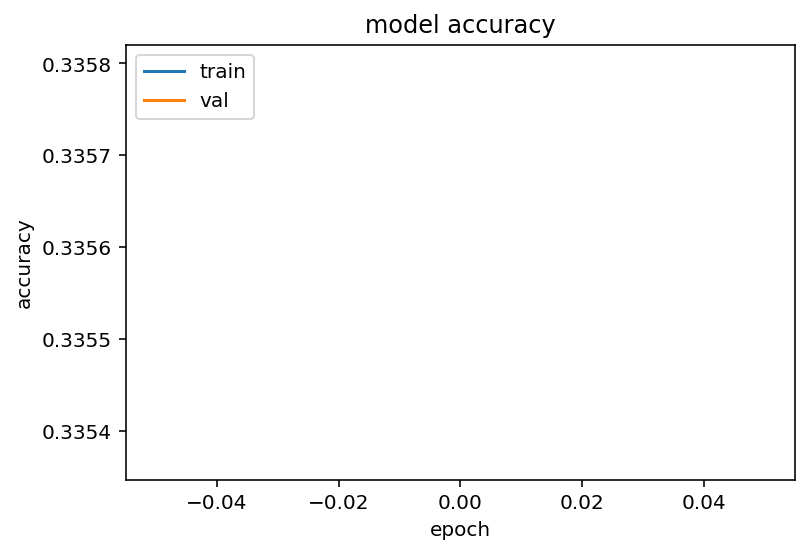

In [18]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

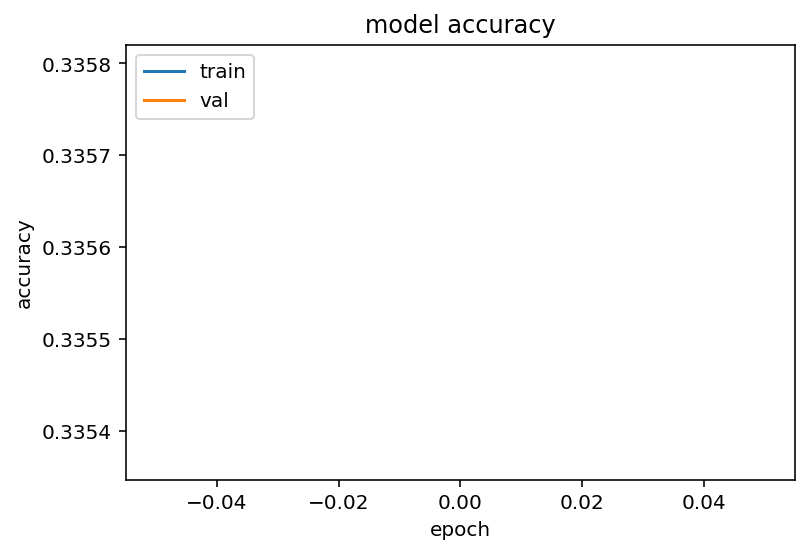

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [20]:
len(glob.glob(train_path + '**/*.midi', recursive=True))

5